In [43]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
# root mean squared error (RMSE) or mean absolute error (MAE)
from math import sqrt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import r2_score
   


In [44]:
def model_building(X_train, y_train, X_test, y_test, look_back,scaler,results): 
                
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
                
    model = Sequential()
    model.add(LSTM(64, input_shape=(1, look_back), return_sequences=True))
    model.add(LSTM(32, return_sequences=True))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=5, verbose=0)
    
    #------ Prediction ------ #
    
    train_predict = model.predict(X_train)
    train_predict = scaler.inverse_transform(train_predict)
    
    test_predict = model.predict(X_test)
    test_predict = scaler.inverse_transform(test_predict)
    
    y_train = scaler.inverse_transform(y_train.reshape(-1,1))
    y_test = scaler.inverse_transform(y_test.reshape(-1,1))
   
    results['RMSE'].append(sqrt(mean_squared_error(y_test,test_predict)))
    results['MAE'].append(mean_absolute_error(y_test,test_predict))
    results['R2'].append(r2_score(y_test,test_predict))
    results["MSE"].append(mean_squared_error(y_test,test_predict))

    joined_data = np.concatenate((train_predict,test_predict),axis=0)
    return train_predict, test_predict,joined_data,model
  

In [45]:
from matplotlib import pyplot as plt
from bokeh.io import output_notebook
output_notebook()

def plotting(trainPredictPlot, testPredictPlot):

    # initialize testPredictPlot with NaN values
    testPredictPlot_empty = np.empty_like(trainPredictPlot)
    testPredictPlot_empty[:] = np.nan
    
    # now concatenate trainPredictPlot with testPredictPlot
    testPredictPlot = np.concatenate((testPredictPlot_empty, testPredictPlot), axis=0)

    
    plt.plot(trainPredictPlot, label='Train data')
    
    plt.plot(testPredictPlot, label='Predicted data')
    #plt.plot(joined, label='Joined data',color='black')
    plt.legend()

    plt.show()
    

Loading BokehJS ...

In [46]:
def stacked_lstm(financial_data,record_to_plot:int=2000):
    financial_data = financial_data.reset_index()
    financial_data = financial_data[:record_to_plot]
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(np.array(financial_data['Close']).reshape(-1, 1))
    
    # Splitting dataset into train and test split
    # As we are using time series data, we need to split the data in train and test on the basis of time not just take the first 80% data as train and remaining as test
    
    from sklearn.model_selection import TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=6)
    print(tscv)
    results = {
        "RMSE":[],
        "MAE":[],
        "R2":[],
        "MSE":[]
    }
        
    for train_index, test_index in tscv.split(scaled_data):
    
        train = scaled_data[train_index]
        test = scaled_data[test_index]
     
        def create_dataset(dataset, look_back:int=0):
            X, Y = [], []
            for i in range(len(dataset)-look_back-1):
                a = dataset[i:(i+look_back)]
                X.append(a)
                Y.append(dataset[i + look_back])
            return np.array(X), np.array(Y)
        
        
        lookback = 1
        X_train, y_train = create_dataset(train, lookback)
        X_test, y_test = create_dataset(test, lookback)
        

        
        trainPredictPlot, testPredictPlot,joined,model = model_building(X_train,y_train,X_test,y_test,lookback,scaler,results)

        true_data = financial_data['Close']
        plotting(trainPredictPlot, testPredictPlot)
    
    
    return true_data,joined,model,results
            

In [47]:
financial_data = pd.read_csv(
    "..\data\EURUSD_Candlestick_4_Hour_ASK_05.05.2003-16.10.2021.csv")

# delete dollar sign
try:
    # Clean up dollar signs and convert columns to numeric values
    financial_data["Close/Last"] = financial_data["Close/Last"].str.replace(
        "$", "").astype(float)
    financial_data["Open"] = financial_data["Open"].str.replace(
        "$", "").astype(float)
    financial_data["High"] = financial_data["High"].str.replace(
        "$", "").astype(float)
    financial_data["Low"] = financial_data["Low"].str.replace(
        "$", "").astype(float)
except Exception:
    pass

# rename the headers
try:
    financial_data.rename(columns={"Close/Last": "Close"}, inplace=True)
except Exception:
    pass


In [48]:
financial_data.rename(columns={"high": "High"}, inplace=True)
financial_data.rename(columns={"low": "Low"}, inplace=True)
financial_data.rename(columns={"open": "Open"}, inplace=True)
financial_data.rename(columns={"volume": "Volume"}, inplace=True)
financial_data.rename(columns={"close": "Close"}, inplace=True)


financial_data = financial_data.reset_index(drop=True)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=6, test_size=None)


9/9 [==============================] - 1s 4ms/step


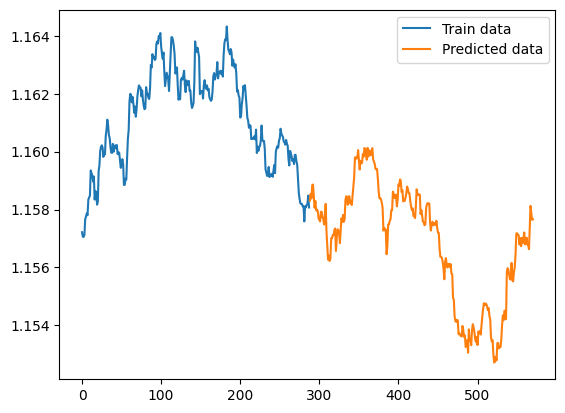

9/9 [==============================] - 0s 3ms/step


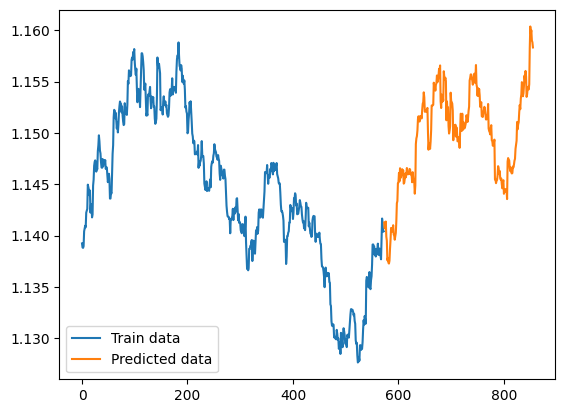

9/9 [==============================] - 0s 9ms/step


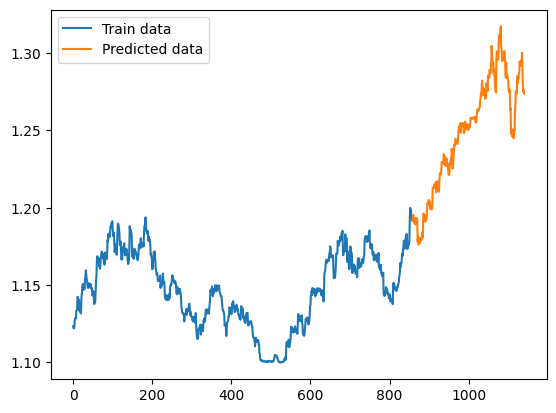

9/9 [==============================] - 0s 5ms/step


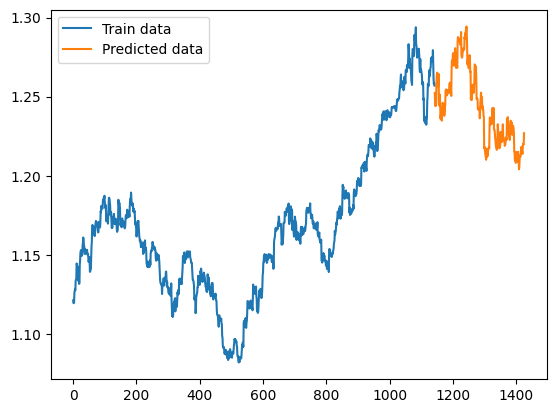

9/9 [==============================] - 0s 6ms/step


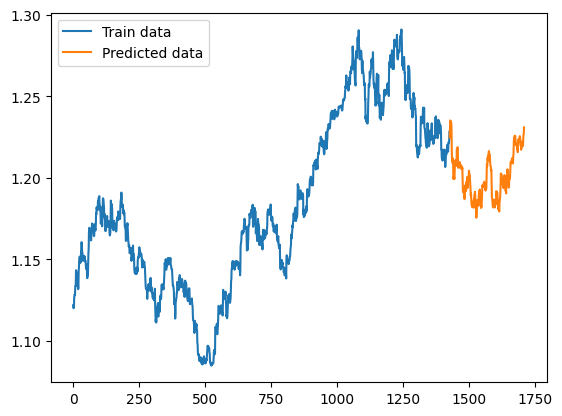

9/9 [==============================] - 0s 5ms/step


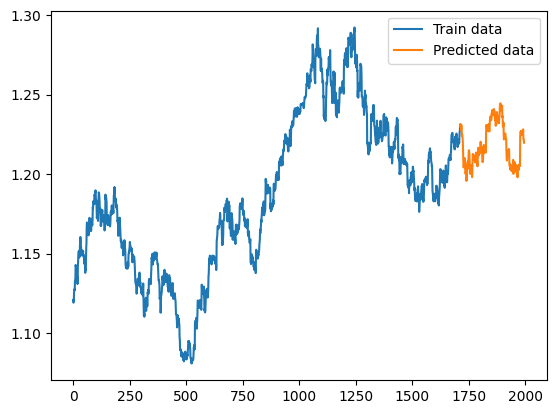

RMSE:  0.014
MAE:  0.012
R2:  0.029
MSE:  0.0


In [49]:
true_data,joined,model,results= stacked_lstm(financial_data,record_to_plot=2000)
print("RMSE: ",round(np.mean(results['RMSE']),3))
print("MAE: ",round(np.mean(results['MAE']),3))
print("R2: ",round(np.mean(results['R2']),3))
print("MSE: ",round(np.mean(results['MSE']),3))
